In [14]:
import gudhi
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import gudhi.representations
from itertools import combinations
import seaborn as sns
from gudhi.hera import wasserstein_distance
from gudhi.hera import bottleneck_distance
from collections import defaultdict
from scipy.interpolate import interp1d

In [15]:
def nodesExtractorC(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractorC(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def nodesExtractorH(name): #extracts nodes and their corresponding information
    file_path = 'Pruned/Pruned_Network_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['nodesC3']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractorH(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Pruned/Pruned_Network_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def inputForGUDHI(name, direction, height): #height is 1 for x, 2 for y, 3 for z
    #this creates the correct data format for GUDHI to run 0-D persistence
    edge_df = edgesExtractorC(name)
    node_df = nodesExtractorC(name)
    edges = list(edge_df.iloc[:,[1,2]].itertuples(index=False,name=None))
    if direction=='pos':
        node_heights = dict(zip(node_df.iloc[:,0],node_df.iloc[:,height]))
    elif direction=='neg':
        node_heights = dict(zip(node_df.iloc[:,0],437-node_df.iloc[:,height]))#CHANGE 437 IF NODES/EDGES ARE NO LONGER IN VOXELS
    return edges, node_heights

In [16]:
def nodesToArrayC(name):
    nodes_df = nodesExtractorC(name)
    nodes_loc = nodes_df.loc[:,['X','Y','Z']]/1000
    loc_array = nodes_loc.to_numpy()
    return loc_array

def nodesToArrayH(name):
    nodes_df = nodesExtractorH(name)
    nodes_loc = nodes_df.loc[:,['X','Y','Z']]/1000
    loc_array = nodes_loc.to_numpy()
    return loc_array

def compute_persistence(points):
    alpha_complex = gudhi.AlphaComplex(points=points)
    simplex_tree = alpha_complex.create_simplex_tree()
    simplex_tree.compute_persistence()
    return simplex_tree.persistence()

def average_curves(curve_dicts, resolution=100):
    """
    Generic averaging function for any type of curve dicts (Betti, lifespan, etc.)
    curve_dicts: list of dicts {dim: (grid, curve)}
    Returns: dict {dim: (common_grid, avg_curve)}
    """
    average = {}

    dims = set().union(*(d.keys() for d in curve_dicts))

    for dim in dims:
        all_grids, all_curves = [], []
        for cdict in curve_dicts:
            if dim not in cdict:
                continue
            grid, curve = cdict[dim]
            if len(grid) == 0:
                continue
            all_grids.append(grid)
            all_curves.append(curve)

        if not all_grids:
            average[dim] = (np.array([]), np.zeros(resolution))
            continue

        global_min = min(g[0] for g in all_grids)
        global_max = max(g[-1] for g in all_grids)
        common_grid = np.linspace(global_min, global_max, resolution)

        interpolated = []
        for grid, curve in zip(all_grids, all_curves):
            f = interp1d(grid, curve, bounds_error=False, fill_value=0)
            interpolated.append(f(common_grid))

        avg_curve = np.mean(interpolated, axis=0)
        average[dim] = (common_grid, avg_curve)

    return average

In [17]:
pressure = '4'

datasets = {
    'm1053007': nodesToArrayH('m1p'+pressure+'_053007'),
    'm2053007': nodesToArrayH('m2p'+pressure+'_053007'),
    'm1053107': nodesToArrayH('m1p'+pressure+'_053107'),
    'm2053107': nodesToArrayH('m2p'+pressure+'_053107'),
    'm1060107': nodesToArrayH('m1p'+pressure+'_060107'),
    'm1060407': nodesToArrayC('m1p'+pressure+'_060407'),
    'm2060407': nodesToArrayC('m2p'+pressure+'_060407'),
    'm3060407': nodesToArrayC('m3p'+pressure+'_060407'),
    'm1060507': nodesToArrayC('m1p'+pressure+'_060507'),
    'm2060507': nodesToArrayC('m2p'+pressure+'_060507'),
    'm3060507': nodesToArrayC('m3p'+pressure+'_060507'),
    'm2060607': nodesToArrayC('m2p'+pressure+'_060607'),
    'm3060607': nodesToArrayC('m3p'+pressure+'_060607'),
}

# Step 1: Compute persistence diagrams
persistence_diagrams = {
    name: compute_persistence(points)
    for name, points in datasets.items()
}

# O-D Height Filtration

/Users/jmmill27/SGext/build/Geometries/networkProcessing/.venv/lib/python3.9/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Axes: title={'center': 'Persistence barcode'}>

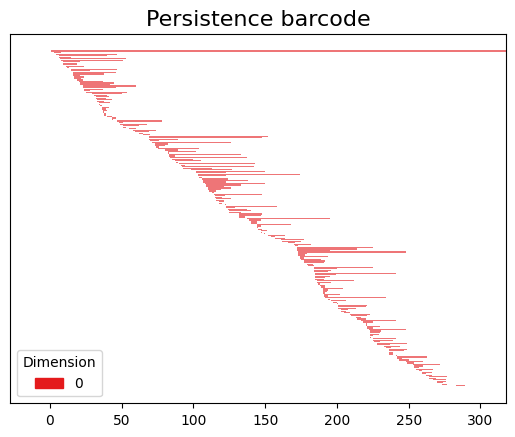

In [3]:
edges,node_heights = inputForGUDHI('m3p4_060407','pos',1)

st = gudhi.SimplexTree()

#adds vertices assigned to their height as the filtration value
for node,height in node_heights.items():
    st.insert([node],filtration=height)

#adds edges with the maximum height as filtration value
for u,v in edges:
    filt_value = max(node_heights[u],node_heights[v])
    st.insert([u,v],filtration=filt_value)

st.make_filtration_non_decreasing()

st.compute_persistence()
gudhi.plot_persistence_barcode(st.persistence())

/Users/jmmill27/SGext/build/Geometries/networkProcessing/.venv/lib/python3.9/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Axes: title={'center': 'Persistence barcode'}>

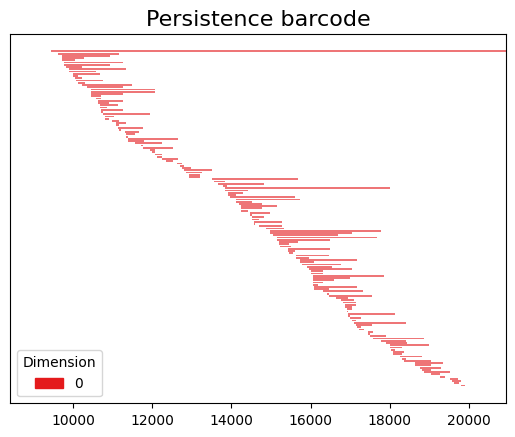

In [72]:
edges,node_heights = inputForGUDHI('m2p4_060407','pos',1)

st = gudhi.SimplexTree()

#adds vertices assigned to their height as the filtration value
for node,height in node_heights.items():
    st.insert([node],filtration=height)

#adds edges with the maximum height as filtration value
for u,v in edges:
    filt_value = max(node_heights[u],node_heights[v])
    st.insert([u,v],filtration=filt_value)

st.make_filtration_non_decreasing()

st.compute_persistence()
gudhi.plot_persistence_barcode(st.persistence())

# Alpha Complex

In [50]:
# Example input arrays (replace these with actual node arrays)
pressure = '1'

datasets = {
    'm1053007': nodesToArrayH('m1p'+pressure+'_053007'),
    'm2053007': nodesToArrayH('m2p'+pressure+'_053007'),
    'm1053107': nodesToArrayH('m1p'+pressure+'_053107'),
    'm2053107': nodesToArrayH('m2p'+pressure+'_053007'),
    'm1060107': nodesToArrayH('m1p'+pressure+'_060107'),
    'm1060407': nodesToArrayC('m1p'+pressure+'_060407'),
    'm2060407': nodesToArrayC('m2p'+pressure+'_060407'),
    'm3060407': nodesToArrayC('m3p'+pressure+'_060407'),
    'm1060507': nodesToArrayC('m1p'+pressure+'_060507'),
    'm2060507': nodesToArrayC('m2p'+pressure+'_060507'),
    'm3060507': nodesToArrayC('m3p'+pressure+'_060507'),
    'm2060607': nodesToArrayC('m2p'+pressure+'_060607'),
    'm3060607': nodesToArrayC('m3p'+pressure+'_060607'),
}

# Compute persistence diagrams
persistence_diagrams = {
    name: compute_persistence(points)
    for name, points in datasets.items()
}


In [51]:
# --- Step 2: Split diagrams by dimension ---
split_diagrams = defaultdict(lambda: defaultdict(list))
for name, diagram in persistence_diagrams.items():
    for dim, pair in diagram:
        split_diagrams[name][dim].append(pair)

# Define which homology dimensions to include
dimensions = [0, 1, 2]  # You can modify this as needed
dimension_weights = {0: 1.0, 1: 1.0, 2: 1.0}  # Optional: adjust weights

# --- Step 3: Compute Wasserstein distances ---
wasserstein_distances = {}

for (name1, diag1), (name2, diag2) in combinations(split_diagrams.items(), 2):
    total_dist = 0.0
    for dim in dimensions:
        pd1 = diag1.get(dim, [])
        pd2 = diag2.get(dim, [])
        if pd1 or pd2:  # Only compute if at least one has data
            #dist = wasserstein_distance(pd1, pd2, order=1., internal_p=2.)
            dist = bottleneck_distance(pd1,pd2)
            weight = dimension_weights.get(dim, 1.0)
            total_dist += weight * dist
    wasserstein_distances[(name1, name2)] = total_dist

# --- Step 4: Build distance matrix ---
names = list(datasets.keys())  # Use original order
distance_matrix = pd.DataFrame(index=names, columns=names, dtype=float)

for name1, name2 in combinations(names, 2):
    dist = wasserstein_distances.get((name1, name2), 0.0)
    distance_matrix.loc[name1, name2] = dist
    distance_matrix.loc[name2, name1] = dist  # Symmetric

np.fill_diagonal(distance_matrix.values, 0.0)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

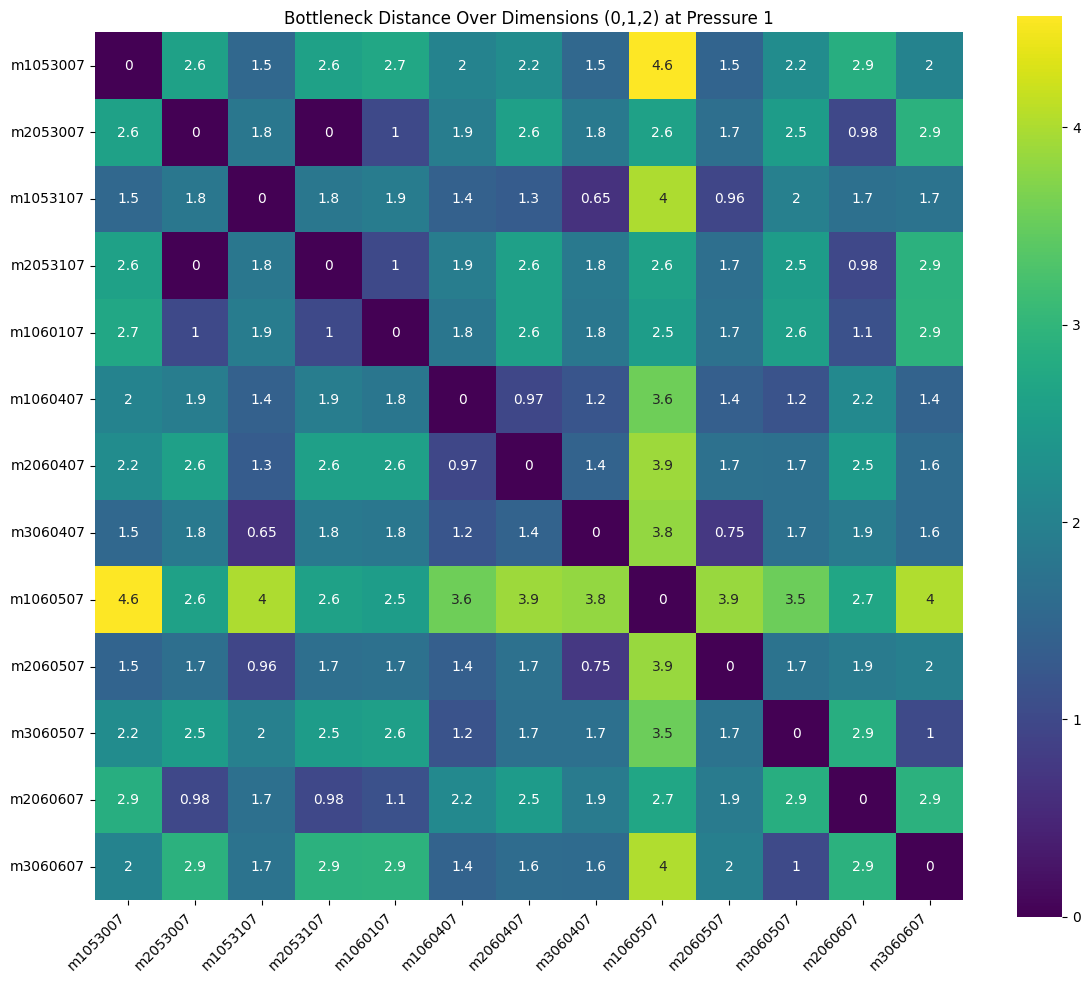

In [ ]:
# --- Step 5: Plot heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, annot=True, cmap='viridis', square=True)
plt.title('Bottleneck Distance Over Dimensions (0,1,2) at Pressure '+pressure)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
#plt.set_title('Title', fontsize=20)
plt.show()

# Pressure 4

In [57]:
# Example input arrays (replace these with actual node arrays)
pressure = '4'

datasets = {
    'm1053007': nodesToArrayH('m1p'+pressure+'_053007'),
    'm2053007': nodesToArrayH('m2p'+pressure+'_053007'),
    'm1053107': nodesToArrayH('m1p'+pressure+'_053107'),
    'm2053107': nodesToArrayH('m2p'+pressure+'_053107'),
    'm1060107': nodesToArrayH('m1p'+pressure+'_060107'),
    'm1060407': nodesToArrayC('m1p'+pressure+'_060407'),
    'm2060407': nodesToArrayC('m2p'+pressure+'_060407'),
    'm3060407': nodesToArrayC('m3p'+pressure+'_060407'),
    'm1060507': nodesToArrayC('m1p'+pressure+'_060507'),
    'm2060507': nodesToArrayC('m2p'+pressure+'_060507'),
    'm3060507': nodesToArrayC('m3p'+pressure+'_060507'),
    'm2060607': nodesToArrayC('m2p'+pressure+'_060607'),
    'm3060607': nodesToArrayC('m3p'+pressure+'_060607'),
}

# Compute persistence diagrams
persistence_diagrams = {
    name: compute_persistence(points)
    for name, points in datasets.items()
}


In [64]:
# --- Step 2: Split diagrams by dimension ---
split_diagrams = defaultdict(lambda: defaultdict(list))
for name, diagram in persistence_diagrams.items():
    for dim, pair in diagram:
        split_diagrams[name][dim].append(pair)

# Define which homology dimensions to include
dimensions = [1]  # You can modify this as needed
dimension_weights = {0: 1.0, 1: 1.0, 2: 1.0}  # Optional: adjust weights

# --- Step 3: Compute Wasserstein distances ---
wasserstein_distances = {}

for (name1, diag1), (name2, diag2) in combinations(split_diagrams.items(), 2):
    total_dist = 0.0
    for dim in dimensions:
        pd1 = diag1.get(dim, [])
        pd2 = diag2.get(dim, [])
        if pd1 or pd2:  # Only compute if at least one has data
            #dist = wasserstein_distance(pd1, pd2, order=1., internal_p=2.)
            dist = bottleneck_distance(pd1,pd2)
            weight = dimension_weights.get(dim, 1.0)
            total_dist += weight * dist
    wasserstein_distances[(name1, name2)] = total_dist

# --- Step 4: Build distance matrix ---
names = list(datasets.keys())  # Use original order
distance_matrix = pd.DataFrame(index=names, columns=names, dtype=float)

for name1, name2 in combinations(names, 2):
    dist = wasserstein_distances.get((name1, name2), 0.0)
    distance_matrix.loc[name1, name2] = dist
    distance_matrix.loc[name2, name1] = dist  # Symmetric

np.fill_diagonal(distance_matrix.values, 0.0)

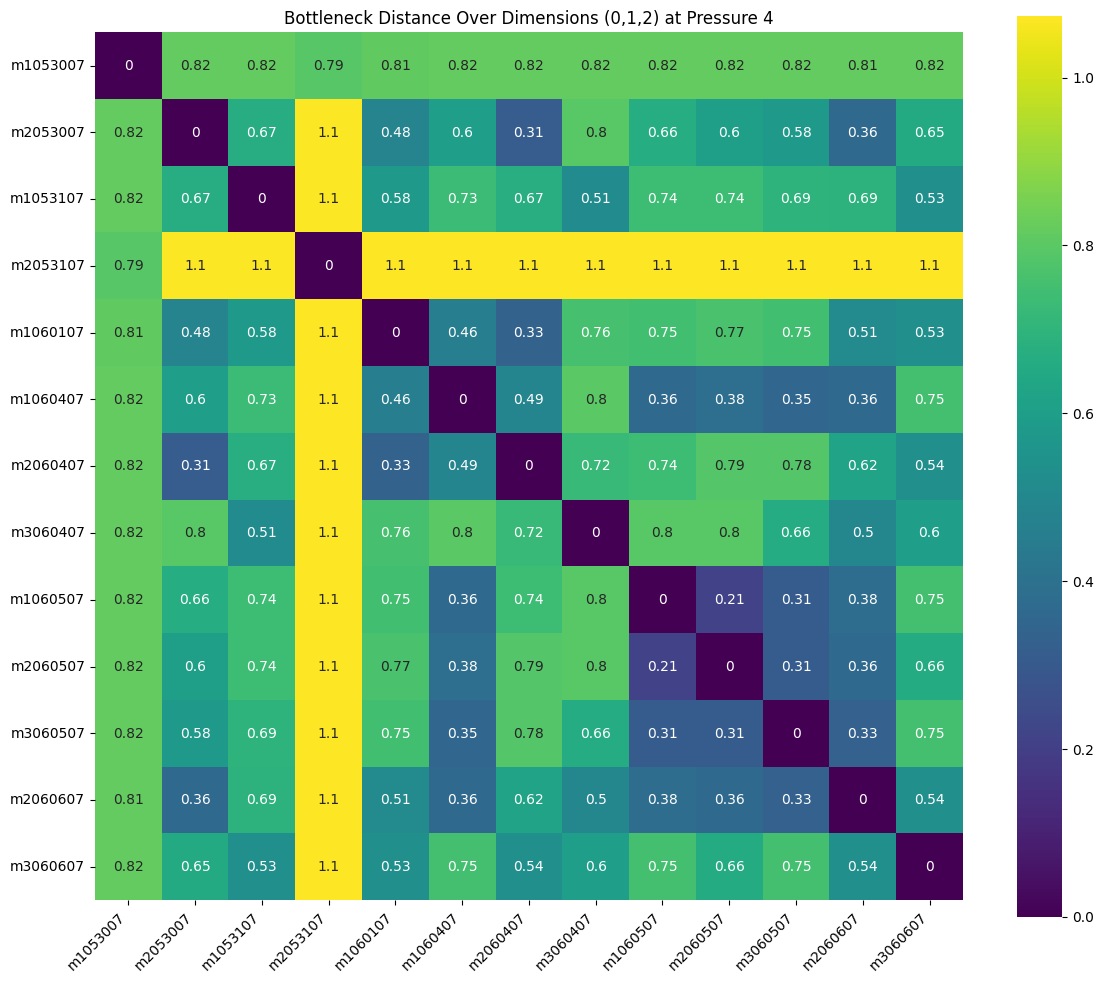

In [65]:
# --- Step 5: Plot heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, annot=True, cmap='viridis', square=True)
plt.title('Bottleneck Distance Over Dimensions (0,1,2) at Pressure '+pressure)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
#plt.set_title('Title', fontsize=20)
plt.show()

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

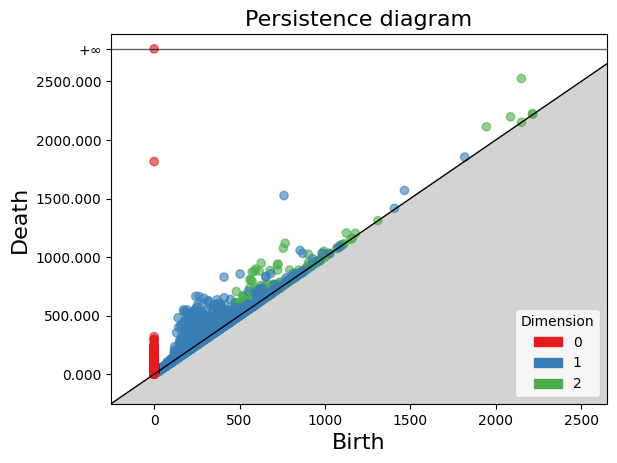

In [ ]:

gudhi.plot_persistence_diagram(alpha_stree.persistence())

Text(0.5, 1.0, 'Persistence Image')

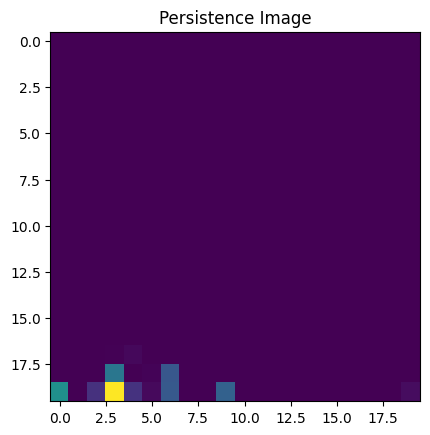

In [ ]:
## Print persistence image for dimension 1 and 2, can't do 0 right now because infinity
PI = gudhi.representations.PersistenceImage()
pi = PI.fit_transform([alpha_stree.persistence_intervals_in_dimension(2)])
plt.imshow(np.flip(np.reshape(pi[0],[20,20]),0))
plt.title('Persistence Image')

In [ ]:
## Lists every simplex
point_loc = nodesToArray('m3p4_060407')

alpha_complex = gudhi.AlphaComplex(points = point_loc)

alpha_stree = alpha_complex.create_simplex_tree()

alpha = alpha_stree.persistence()

for point in alpha:
    dim = point[0]
    bd = point[1]
    print("Dim: ",dim)
    print("(Birth, Death): ",bd)
    print()

Dim:  2
(Birth, Death):  (2150.5181636152374, 2525.7478440871473)

Dim:  2
(Birth, Death):  (766.8560023384189, 1118.4938364963025)

Dim:  2
(Birth, Death):  (626.7524190012209, 947.9418874571119)

Dim:  2
(Birth, Death):  (756.374553530713, 1075.7982594751343)

Dim:  2
(Birth, Death):  (594.9611380196766, 897.6473367719666)

Dim:  2
(Birth, Death):  (574.2987608478518, 871.5304745213659)

Dim:  2
(Birth, Death):  (585.8903544002015, 879.3995124851372)

Dim:  2
(Birth, Death):  (615.1013876454788, 881.1359421918316)

Dim:  2
(Birth, Death):  (560.2031375511599, 808.0455480623206)

Dim:  2
(Birth, Death):  (567.1500178212988, 803.6876999412558)

Dim:  2
(Birth, Death):  (481.1183952129022, 705.4113030663622)

Dim:  2
(Birth, Death):  (573.2529688664127, 791.5231534229513)

Dim:  2
(Birth, Death):  (725.4061076433629, 940.130499477115)

Dim:  2
(Birth, Death):  (721.9195373648536, 933.3809080070782)

Dim:  2
(Birth, Death):  (679.1583442257422, 884.8472078405233)

Dim:  2
(Birth, Death):

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

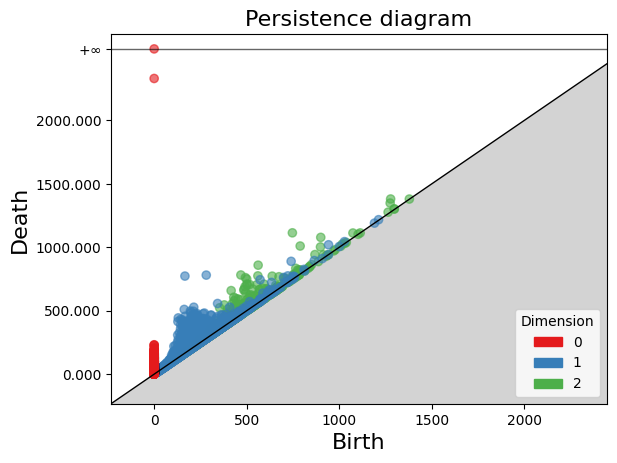

In [6]:
point_loc = nodesToArray('m2p4_053007')

alpha_complex = gudhi.AlphaComplex(points = point_loc)

alpha_stree = alpha_complex.create_simplex_tree()

alpha_stree.compute_persistence()

gudhi.plot_persistence_diagram(alpha_stree.persistence())

# Betti Curves

In [18]:
def compute_betti_curve(diag, max_dim=2, resolution=100):
    """
    Convert persistence diagram into Betti curves.
    Returns dict of {dimension: curve}
    """
    betti_curves = {}
    for dim in range(max_dim + 1):
        diag_dim = np.array([pt[1] for pt in diag if pt[0] == dim])
        if len(diag_dim) == 0:
            betti_curves[dim] = np.zeros(resolution)
            continue
        
        # Replace inf with max finite value
        finite_bars = diag_dim[~np.isinf(diag_dim[:, 1])]
        if len(finite_bars) == 0:
            betti_curves[dim] = np.zeros(resolution)
            continue

        max_val = np.max(finite_bars[:, 1])
        min_val = np.min(finite_bars[:, 0])
        grid = np.linspace(min_val, max_val, resolution)
        curve = np.zeros_like(grid)

        for birth, death in finite_bars:
            curve += (grid >= birth) & (grid <= death)

        betti_curves[dim] = (grid, curve)

    return betti_curves

def plot_multiple_betti_curves(curves_dicts, labels, dimension, title='Betti Curves Comparison'):
    """
    curves_dicts: list of betti_curve dicts {dim: (grid, curve)}
    labels: list of labels for each curve
    dimension: the Betti number (int) to plot
    """
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    linestyles = ['-', '--', '-.', ':']

    for idx, (curve_dict, label) in enumerate(zip(curves_dicts, labels)):
        if dimension in curve_dict:
            grid, curve = curve_dict[dimension]
            if len(grid) > 0:
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                plt.plot(grid, curve, color=color, linestyle=linestyle, label=f'{label} (Betti-{dimension})')
        else:
            print(f"Warning: {label} does not contain Betti-{dimension}")

    plt.title(f'{title} (Betti-{dimension})')
    plt.xlabel('Filtration Value')
    plt.ylabel(f'Betti-{dimension}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [19]:
betti_curves = {
    name: compute_betti_curve(diag)
    for name, diag in persistence_diagrams.items()
}

# Get keys in insertion order
keys = list(betti_curves.keys())

hyper_curves = [betti_curves[k] for k in keys[:5]]
control_curves  = [betti_curves[k] for k in keys[-8:]]

average_control = average_curves(control_curves)
average_hyper = average_curves(hyper_curves)

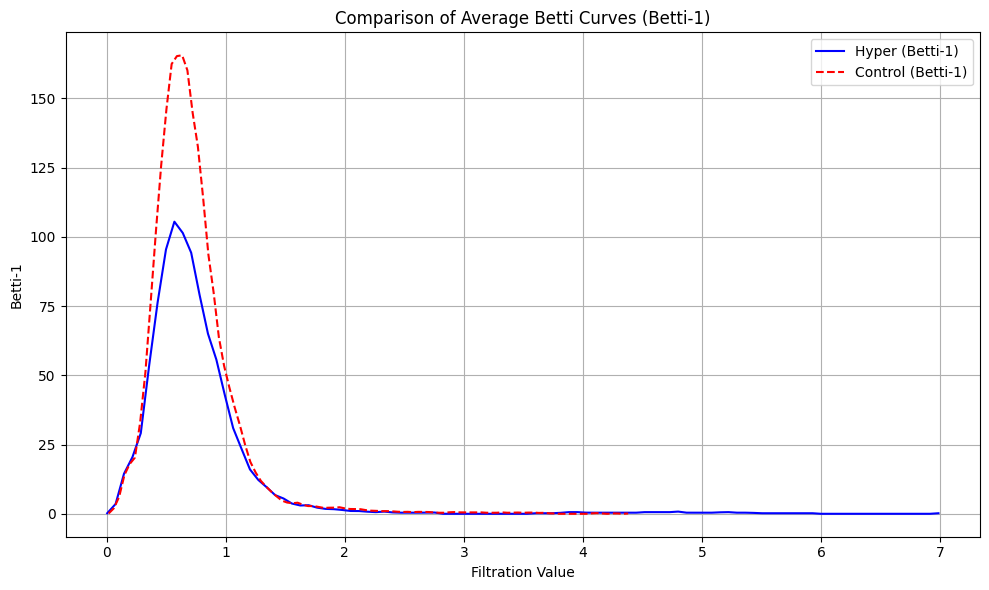

In [25]:
plot_multiple_betti_curves(
    [average_hyper, average_control],
    labels=["Hyper", "Control"], dimension = 1,
    title="Comparison of Average Betti Curves"
)

In [21]:
def plot_named_betti_curves(betti_curves_dict, dimension=0, title='Betti Curves (Dimension 1)'):
    """
    betti_curves_dict: dict of {name: betti_curve_dict}
    Each betti_curve_dict is like {dim: (grid, curve)}
    """
    if len(betti_curves_dict) != 13:
        raise ValueError("Expected 13 Betti curve dicts.")

    plt.figure(figsize=(10, 6))

    for idx, (name, curve_dict) in enumerate(betti_curves_dict.items()):
        if dimension not in curve_dict:
            continue

        grid, curve = curve_dict[dimension]

        if len(grid) == 0:
            continue

        color = 'blue' if idx < 5 else 'red'
        label = name 

        plt.plot(grid, curve, color=color, alpha=0.6, linewidth=1.5, label=label)

    plt.title(title)
    plt.xlabel('Filtration Value')
    plt.ylabel(f'Betti-{dimension}')
    plt.grid(True)

    if plt.gca().get_legend_handles_labels()[0]:
        plt.legend()

    plt.tight_layout()
    plt.show()


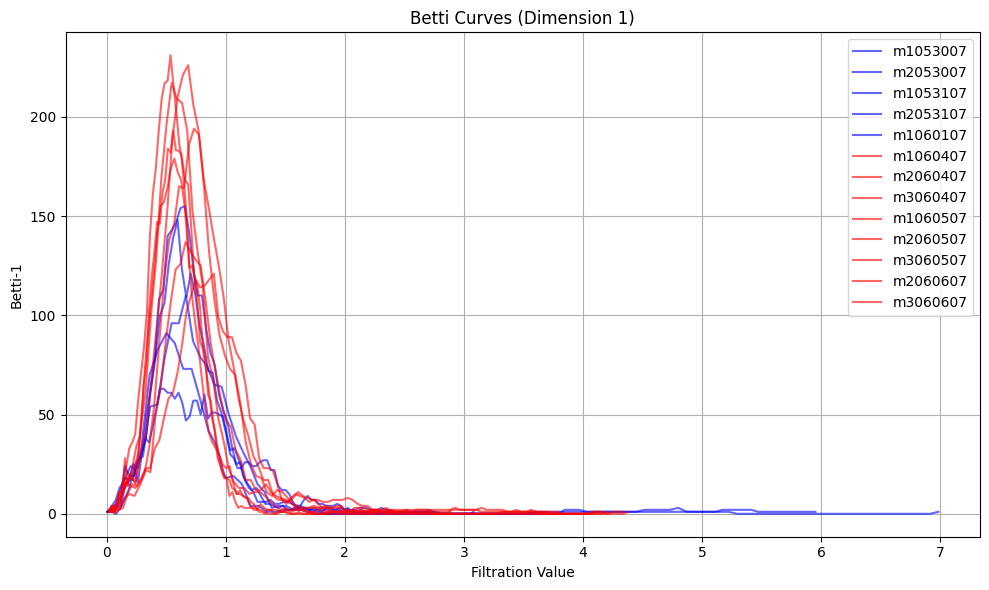

In [22]:
plot_named_betti_curves(betti_curves, dimension=1, title='Betti Curves (Dimension 1)')

# Lifespan Curve

In [27]:
def compute_lifespan_curves(diagram, max_dim=2, resolution=100):
    """
    Computes lifespan curves: at each grid point, sum of lifespans of intervals active.
    Returns: dict {dimension: (grid, curve)}
    """
    lifespan_curves = {}

    for dim in range(max_dim + 1):
        bars = np.array([pt[1] for pt in diagram if pt[0] == dim])
        if len(bars) == 0:
            lifespan_curves[dim] = (np.array([]), np.zeros(resolution))
            continue

        finite = bars[~np.isinf(bars[:, 1])]
        if len(finite) == 0:
            lifespan_curves[dim] = (np.array([]), np.zeros(resolution))
            continue

        birth_min = np.min(finite[:, 0])
        death_max = np.max(finite[:, 1])
        grid = np.linspace(birth_min, death_max, resolution)
        curve = np.zeros_like(grid)

        for birth, death in finite:
            lifespan = death - birth
            curve += ((grid >= birth) & (grid <= death)).astype(float) * lifespan

        lifespan_curves[dim] = (grid, curve)

    return lifespan_curves

def plot_multiple_lifespan_curves(curves_dicts, labels, dimension, title='Lifespan Curves Comparison'):
    """
    curves_dicts: list of betti_curve dicts {dim: (grid, curve)}
    labels: list of labels for each curve
    dimension: the Betti number (int) to plot
    """
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    linestyles = ['-', '--', '-.', ':']

    for idx, (curve_dict, label) in enumerate(zip(curves_dicts, labels)):
        if dimension in curve_dict:
            grid, curve = curve_dict[dimension]
            if len(grid) > 0:
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                plt.plot(grid, curve, color=color, linestyle=linestyle, label=f'{label} (Betti-{dimension})')
        else:
            print(f"Warning: {label} does not contain Betti-{dimension}")

    plt.title(f'{title} (Betti-{dimension})')
    plt.xlabel('Filtration Value')
    plt.ylabel(f'Betti-{dimension}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
lifespan_curves = {
    name: compute_lifespan_curves(diag)
    for name, diag in persistence_diagrams.items()
}

# Get keys in insertion order
keys = list(lifespan_curves.keys())

hyper_curves_life = [lifespan_curves[k] for k in keys[:5]]
control_curves_life  = [lifespan_curves[k] for k in keys[-8:]]

average_control_life = average_curves(control_curves_life)
average_hyper_life = average_curves(hyper_curves_life)

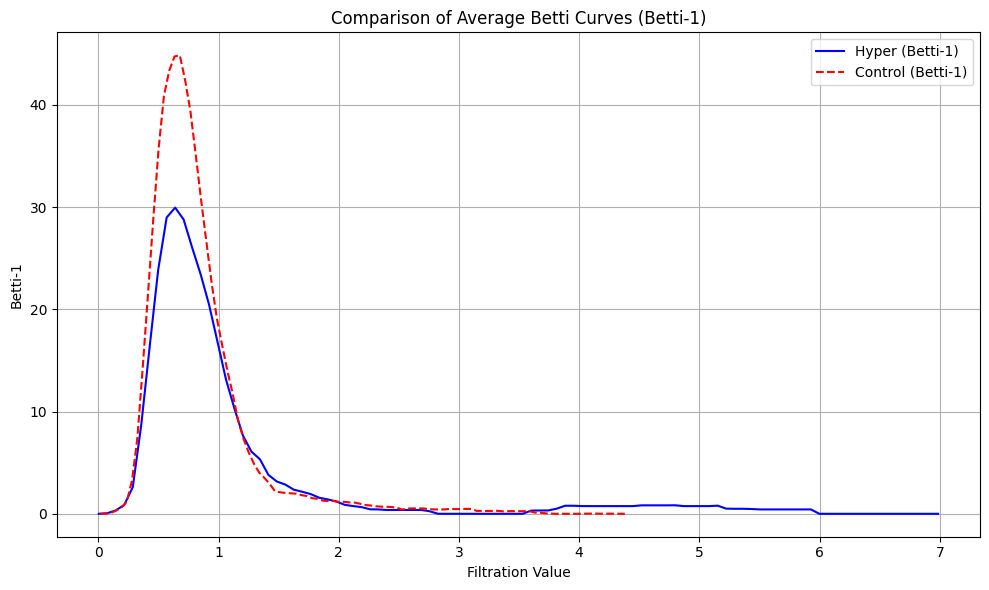

In [30]:
plot_multiple_lifespan_curves(
    [average_hyper_life, average_control_life],
    labels=["Hyper", "Control"], dimension = 1,
    title="Comparison of Average Betti Curves"
)

# Normalized Betti

In [109]:
def normalize_betti_curves(betti_curves, method='max'):
    """
    Normalize Betti curves using specified method.
    method: 'area' | 'max' | 'sum'
    """
    normalized = {}

    for dim, (grid, curve) in betti_curves.items():
        if len(grid) == 0:
            normalized[dim] = (grid, curve)
            continue

        if method == 'area':
            norm = np.trapz(curve, grid)
        elif method == 'max':
            norm = np.max(curve)
        elif method == 'sum':
            norm = np.sum(curve)
        else:
            raise ValueError(f"Unknown normalization method: {method}")

        if norm > 0:
            normalized_curve = curve / norm
        else:
            normalized_curve = curve

        normalized[dim] = (grid, normalized_curve)

    return normalized

def plot_multiple_norm_betti_curves(curves_dicts, labels, dimension, title='Norm Betti Curves Comparison'):
    """
    curves_dicts: list of betti_curve dicts {dim: (grid, curve)}
    labels: list of labels for each curve
    dimension: the Betti number (int) to plot
    """
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    linestyles = ['-', '--', '-.', ':']

    for idx, (curve_dict, label) in enumerate(zip(curves_dicts, labels)):
        if dimension in curve_dict:
            grid, curve = curve_dict[dimension]
            if len(grid) > 0:
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                plt.plot(grid, curve, color=color, linestyle=linestyle, label=f'{label} (Betti-{dimension})')
        else:
            print(f"Warning: {label} does not contain Betti-{dimension}")

    plt.title(f'{title} (Betti-{dimension})')
    plt.xlabel('Filtration Value')
    plt.ylabel(f'Betti-{dimension}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
norm_betti_curves = {
    name: normalize_betti_curves(diag)
    for name, diag in persistence_diagrams.items()
}

# Get keys in insertion order
keys = list(lifespan_curves.keys())

hyper_curves_life = [lifespan_curves[k] for k in keys[:5]]
control_curves_life  = [lifespan_curves[k] for k in keys[-8:]]

average_control_life = average_curves(control_curves_life)
average_hyper_life = average_curves(hyper_curves_life)